### Project Content
There are two main steps in the pipeline of this project:
- Data collection from linkedin websites
- Data analysis for job market trend

In [2]:
#sys libraries
from time import sleep
import requests
import random
import csv
import io
import os
import sys
import types
import getpass
import string
import re
from bs4 import BeautifulSoup

# Import data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# nltk and wordcloud
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows' , 100)

### Data Collection

>First, I do not condone scraping LinkedIn data in any way. Anyone who wishes to do so should first read <a href = 'https://www.linkedin.com/help/linkedin/answer/56347/prohibition-of-scraping-software?lang=enprohibition'>  LinkedIn's statement </a> on their of scraping software. 

>Also, note that LinkedIn actively suspends accounts due to <b>excessive activity</b> on a given account.

This code is to be used for learning purposes only and should not be used a tool for any commercial purpose. 

Usually, people use a library named Beautifulsoup to scrape web. Web scraping with Beautifulsoup extracts content from static HTML pages and it cannot be used to scrape some websites that don’t want others to obtain data from them, such as LinkedIn. To solve this issue, I use a more advanced package called Selenium to mimic a real human user interacting with the web pages. It directly controls the browser by programmatically clicking links and filling in login information, which reduces the probability of being blocked by LinkedIn.So I used selenium and beautiful soup to web-scrape Data Scientist in United Kingdom on LinkedIn. 
The first challenge we met is that we have to make sure each action our program achieved is exactly the same as the real operations by humans. Selenium has a restriction on its speed because the scraping with the browser is much slower. Due to the slowness, to not get banned by LinkedIn the use of the "sleep" statements had to be used in my code multiple times to cause further slow-down. For example, if you don’t set enough of a waiting time to make sure the web page is loaded fully, you will lose part of the information. And if you want to click on the links or buttons in the web page, you have to make sure they are viewable in your browser. Otherwise, LinkedIn will regard you as a robot and block your access since humans cannot click on anything invisible.
The most challenging part is from the LinkedIn website. It has various methods to prevent external scraping. First, each Linkedln account can only access the first 100 pages of the search results. Second, some profiles may appear repeatedly in different result pages, which causes duplicate records occurring in our data. These problems limit the amount of data we can collect.
This issue is solved by networking method. I found every profile page has a section called “People Also Viewed”. This section contains a list of ten people who work in similar fields with the profile owner. We can regard the profile we have already collected as seeds and then extend the network with this connection. In this way, LinkedIn won’t set a visit limitation for the profiles and the amount of data is grows exponentially.

I scape the scraping part and start the data cleaning process:


## Exploratory Data Analysis (EDA)

In [324]:
# Reading from scv file
df = pd.read_csv('result_unique.csv',index_col=False)
df.head()

name  \
0     Andria Sarri   
1   Saksham Jindal   
2  sasan raeissian   
3    Rahul Jaiswal   
4       Subbarao Y   

                                                      job_title  \
0                                                Data Scientist   
1                           Data Scientist at Fractal Analytics   
2                 Senior Data Scientist at LGS - An IBM Company   
3                            Data Scientist at HCL Technologies   
4  Artificial Intelligence machine learning - Chatbot developer   

        current_company                                 university  \
0                  HSBC                                        UCL   
1     Fractal Analytics  Indian Institute of Technology, Kharagpur   
2  LGS - An IBM Company                     Université de Montréal   
3      HCL Technologies                      Academy of Technology   
4              DBS Bank                                        NaN   

                                                                             degree  \
0                                                      Doctor of Philosophy (Ph.D.)   
1  Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
2                                                           Master of Science (MSc)   
3                                                    BTech - Bachelor of Technology   
4                                                                               NaN   

                                 location  \
0  London, Greater London, United Kingdom   
1                  London, United Kingdom   
2                   Montreal, Canada Area   
3                  London, United Kingdom   
4          Nellore, Andhra Pradesh, India   

                                                                                                 about  \
0                                                                                                  NaN   
1                                                                                                  NaN   
2  Summary of qualifications\r\n\r\nProfessionally qualified statistician with strong programming b...   
3  Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
4  *IT Professional with 11 Years of Experience in Software industry.\r\n*good working knowledge on...   

          skills                                            present_url  
0  Data Analysis               https://www.linkedin.com/in/andriasarri/  
1            C++   https://www.linkedin.com/in/saksham-jindal-52b7b47a/  
2            NaN  https://www.linkedin.com/in/sasan-raeissian-b4b1a034/  
3            NaN    https://www.linkedin.com/in/rahul-jaiswal-570042ab/  
4            NaN      https://www.linkedin.com/in/subbarao-y-1547a8134/

In [4]:
# find number of missing data based on each column
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("\n")

name
False    765
Name: name, dtype: int64


job_title
False    765
Name: job_title, dtype: int64


current_company
False    764
True       1
Name: current_company, dtype: int64


university
False    518
True     247
Name: university, dtype: int64


degree
False    614
True     151
Name: degree, dtype: int64


location
False    765
Name: location, dtype: int64


about
True     422
False    343
Name: about, dtype: int64


skills
True     723
False     42
Name: skills, dtype: int64


present_url
False    765
Name: present_url, dtype: int64




In [8]:
# let see is there anyone from outside UK in our dataset
df['location'].value_counts().to_frame().reset_index()

index  location
0            London, Greater London, United Kingdom       156
1                            London, United Kingdom       143
2                                    United Kingdom        92
3                                              Iran        87
4    Manchester, Greater Manchester, United Kingdom        17
..                                              ...       ...
145              Old Woking, Surrey, United Kingdom         1
146        Churchgate Street, Essex, United Kingdom         1
147                 Bath, Bath Avon, United Kingdom         1
148      Chesterton, Cambridgeshire, United Kingdom         1
149                       South Delhi, Delhi, India         1

[150 rows x 2 columns]

In [326]:
# we just want those who are in UK so:
uk_df = df[df['location'].str.contains("United Kingdom")]
print("Number of records from Uk: ", uk_df.shape[0])

Number of records from Uk:  592


In [10]:
uk_df['location'].value_counts().to_frame().reset_index()

index  location
0            London, Greater London, United Kingdom       156
1                            London, United Kingdom       143
2                                    United Kingdom        92
3    Manchester, Greater Manchester, United Kingdom        17
4                        Manchester, United Kingdom        14
..                                              ...       ...
104                          Ilford, United Kingdom         1
105                        Southall, United Kingdom         1
106                         Swindon, United Kingdom         1
107        St Albans, Hertfordshire, United Kingdom         1
108                      Colchester, United Kingdom         1

[109 rows x 2 columns]

In [11]:
uk_df[['city','region', 'country']] = df['location'].str.split(',',expand=True)
uk_df

C:\Users\behdad\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


name                                           job_title  \
0           Andria Sarri                                      Data Scientist   
1         Saksham Jindal                 Data Scientist at Fractal Analytics   
3          Rahul Jaiswal                  Data Scientist at HCL Technologies   
5         Vaibhav Sharma                           Data Scientist at ZappyAI   
6            Paras Ahuja                               Data Scientist at Jio   
..                   ...                                                 ...   
760     Anna Padkavyrava                       Data Scientist at Brave Bison   
761   Konstantinos Bozas  Senior Data Scientist at Amazon | Machine Learning   
762         Nadbor Drozd         Lead Data Scientist at Lloyds Banking Group   
763  Christopher Ottesen                                      Data Scientist   
764            Ben Adler                   Data Scientist - NLP at Logically   

          current_company  \
0                    HSBC   
1       Fractal Analytics   
3        HCL Technologies   
5                 ZappyAI   
6                     Jio   
..                    ...   
760           Brave Bison   
761                Amazon   
762  Lloyds Banking Group   
763                    BP   
764             Logically   

                                                          university  \
0                                                                UCL   
1                          Indian Institute of Technology, Kharagpur   
3                                              Academy of Technology   
5                                             London Business School   
6                                                                NaN   
..                                                               ...   
760  Belarusian State University of Informatics and Radioelectronics   
761                                         Queen Mary, U. of London   
762                                             University of Warsaw   
763                                                              NaN   
764                                              University of Leeds   

                                                                               degree  \
0                                                        Doctor of Philosophy (Ph.D.)   
1    Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
3                                                      BTech - Bachelor of Technology   
5                                                 Masters in Analytics and Management   
6                                                                                 NaN   
..                                                                                ...   
760                                                                   Master’s Degree   
761                                                                               PhD   
762                                                                               M.S   
763                                                                               NaN   
764                                                                               BSc   

                                   location  \
0    London, Greater London, United Kingdom   
1                    London, United Kingdom   
3                    London, United Kingdom   
5    London, Greater London, United Kingdom   
6                    London, United Kingdom   
..                                      ...   
760  London, Greater London, United Kingdom   
761                  London, United Kingdom   
762  London, Greater London, United Kingdom   
763  London, Greater London, United Kingdom   
764         Farnham, Surrey, United Kingdom   

                                                                                                   about  \
0                                                                                                    Na

In [327]:
# find number of missing data based on each column
missing_data = uk_df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("\n")

name
False    592
Name: name, dtype: int64


job_title
False    592
Name: job_title, dtype: int64


current_company
False    592
Name: current_company, dtype: int64


university
False    435
True     157
Name: university, dtype: int64


degree
False    513
True      79
Name: degree, dtype: int64


location
False    592
Name: location, dtype: int64


about
True     330
False    262
Name: about, dtype: int64


skills
True     573
False     19
Name: skills, dtype: int64


present_url
False    592
Name: present_url, dtype: int64




### Do some cleaning and exploring on data
as you can see we have 775 rows × 11 columns. There some rows with null values. Because when we use selenium and getting elements with their class and atributes it has a chance that you got nothing!
We want to explore job applications description so let 's filter data by description

#### working on jobs

In [329]:
jobs=uk_df[uk_df['job_title'].notnull()]
jobs

name                                           job_title  \
0           Andria Sarri                                      Data Scientist   
1         Saksham Jindal                 Data Scientist at Fractal Analytics   
3          Rahul Jaiswal                  Data Scientist at HCL Technologies   
5         Vaibhav Sharma                           Data Scientist at ZappyAI   
6            Paras Ahuja                               Data Scientist at Jio   
..                   ...                                                 ...   
760     Anna Padkavyrava                       Data Scientist at Brave Bison   
761   Konstantinos Bozas  Senior Data Scientist at Amazon | Machine Learning   
762         Nadbor Drozd         Lead Data Scientist at Lloyds Banking Group   
763  Christopher Ottesen                                      Data Scientist   
764            Ben Adler                   Data Scientist - NLP at Logically   

          current_company  \
0                    HSBC   
1       Fractal Analytics   
3        HCL Technologies   
5                 ZappyAI   
6                     Jio   
..                    ...   
760           Brave Bison   
761                Amazon   
762  Lloyds Banking Group   
763                    BP   
764             Logically   

                                                          university  \
0                                                                UCL   
1                          Indian Institute of Technology, Kharagpur   
3                                              Academy of Technology   
5                                             London Business School   
6                                                                NaN   
..                                                               ...   
760  Belarusian State University of Informatics and Radioelectronics   
761                                         Queen Mary, U. of London   
762                                             University of Warsaw   
763                                                              NaN   
764                                              University of Leeds   

                                                                               degree  \
0                                                        Doctor of Philosophy (Ph.D.)   
1    Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
3                                                      BTech - Bachelor of Technology   
5                                                 Masters in Analytics and Management   
6                                                                                 NaN   
..                                                                                ...   
760                                                                   Master’s Degree   
761                                                                               PhD   
762                                                                               M.S   
763                                                                               NaN   
764                                                                               BSc   

                                   location  \
0    London, Greater London, United Kingdom   
1                    London, United Kingdom   
3                    London, United Kingdom   
5    London, Greater London, United Kingdom   
6                    London, United Kingdom   
..                                      ...   
760  London, Greater London, United Kingdom   
761                  London, United Kingdom   
762  London, Greater London, United Kingdom   
763  London, Greater London, United Kingdom   
764         Farnham, Surrey, United Kingdom   

                                                                                                   about  \
0                                                                                                    Na

In [330]:
#let 's see which title has the most profiessional in united kingdom!
jobs['job_title'].value_counts().to_frame().reset_index()

index  job_title
0                     Data Scientist        144
1         Data Scientist at Facebook         12
2              Data Scientist at Sky          6
3                Lead Data Scientist          4
4            Data Scientist at Aviva          4
..                               ...        ...
365       Data Scientist at Kognitio          1
366     Data Scientist at Findmypast          1
367  Applied Researcher at Tractable          1
368         Data Scientist at Aiqudo          1
369           Data Scientist at GSMA          1

[370 rows x 2 columns]

In [331]:
# find number of missing data based on each column
missing_data = jobs.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("\n")

name
False    592
Name: name, dtype: int64


job_title
False    592
Name: job_title, dtype: int64


current_company
False    592
Name: current_company, dtype: int64


university
False    435
True     157
Name: university, dtype: int64


degree
False    513
True      79
Name: degree, dtype: int64


location
False    592
Name: location, dtype: int64


about
True     330
False    262
Name: about, dtype: int64


skills
True     573
False     19
Name: skills, dtype: int64


present_url
False    592
Name: present_url, dtype: int64




In [332]:
jobs['skills'].unique()

array(['Data Analysis', 'C++', nan, 'Microsoft Excel', 'R',
       'Mathematical Modeling', 'Python', 'Research',
       'Project Management', 'Data Analytics', 'Engineering', 'Teamwork',
       'Mathematics', 'Statistics', 'Bioinformatics'], dtype=object)

In [333]:
from nltk.stem.wordnet import WordNetLemmatizer
import string

jobs['about'].fillna('',inplace=True)

skills_in_about = ['python' , 'R' , 'sql' , 'java' , 'c++' , 'data analysis' , 'machine learning' , 'matlab' , 'excel' ,'NLP',
                  'Statistical analysis']


lem = WordNetLemmatizer() 
fcn = lambda x: " ".join(set([lem.lemmatize(w, 'v') for w in x]).intersection(set(skills_in_about)))
jobs['skills_new'] = jobs['about'].str.split().apply(fcn)
jobs['skills_new'].unique()

array(['', 'NLP', 'R', 'python', 'R excel', 'R NLP', 'sql R python',
       'excel'], dtype=object)

In [334]:
jobs.tail(100)

name  \
596                               Ralph Surkyn   
597                             Garima Agarwal   
599                             SSENNOGA TWAHA   
600                                  Joe Wandy   
601                                  Tom Kealy   
602                                Matt McCall   
603                              Oyin Yemidale   
621                              leila soltani   
632                             Thanh-Thuy NGO   
633                               Daria Kulach   
634                              Aaron Gilmore   
635                                Lewis Burke   
636                                  Jordan L.   
637                        Jiyan Babaie-Harmon   
638                               Felicity Liu   
639  Yash Bolarum - Medical and Tech Marketing   
640                               Simon Davies   
641                                  Ryan Hall   
642                                   Ian Watt   
644                    Bethany Rodgers-Rintoul   
645                             Farrah Mohamed   
646                                    Jans B.   
647                             Merlyn Gregory   
649                              Sorath Soomro   
650                              Eyüp TEKKANAT   
651                                Ayca Kandur   
652                            Ana Camila Baez   
662                               Ralph Surkyn   
663                              Oyin Yemidale   
667                        Professor Rob Aspin   
668                         Ben Alexander-Dann   
669                                Julian Bass   
670                             Justyna Turner   
671                    Lakshmi Prasoona Tumula   
672                         Lakshmi C Lineshah   
673                              Sana BELGUITH   
674                             Mirco Musolesi   
675                               Sunil Vadera   
676                          Haifa Takruri MBE   
677                           Kallirroi Dogani   
678                                   Joan Lei   
679           Stavroula (Renia) Diamantopoulou   
680                               Emma Katsani   
681                               Sadie Harlow   
682                          Ashleigh Thompson   
683                           Yading Song, PhD   
686                            Jonathan Barker   
687                            Tamsin Chisnall   
688                              Elena Zardeli   
689                          Daniela Del Valle   
690                             Shehzad Darbar   
691                          Gibson Ikoro, PhD   
692                               Kayin Darbey   
693                               George Welch   
694                               Madhur Gupta   
695                              Rachael Saxon   
696                              Khyati Sethia   
697                               Cherie Price   
698                          Abduljabar Alissa   
699                                John Wright   
700                          Georgios Soteriou   
701                            Julia MacMillan   
702                                   Tom Mayo   
703                          Matthew Doubleday   
704                              Shadab Mashuk   
705                                 Raphael L.   
706                          Jellaby Hoi I Lai   
707                              Marcus Dawson   
708                           Michelle Mccurdy   
709                              Hayley Downey   
710                               Thomas Lucas   
711                            Susana Ferreras   
712                               Peter Morris   
713                          Sir Alex Ferguson   
714                                     Ian G.   
715                           Malcolm Harkness   
716                                 Jade aston   
717                              Arjav Trivedi   
739                             Joseph Hamblin   
740                                 Jon In

In [335]:
jobs['skills'].fillna('',inplace=True)
jobs["skills"] = jobs["skills"] + jobs["skills_new"]

In [336]:
del jobs['skills_new']

In [337]:
jobs['skills'].unique()

array(['Data Analysis', 'C++', '', 'NLP', 'R', 'python', 'R excel',
       'R NLP', 'sql R python', 'excel', 'Microsoft Excel',
       'Mathematical Modeling', 'Python', 'Research',
       'Project Management', 'Data Analytics', 'Engineering', 'Teamwork',
       'Mathematics', 'Statistics', 'Bioinformatics'], dtype=object)

In [338]:
def tokenization(text):
    text = text.replace(',', text)
    return text

jobs['skills'] = jobs['skills'].apply(lambda x: tokenization(x.lower()))
jobs.head()

name                            job_title    current_company  \
0    Andria Sarri                       Data Scientist               HSBC   
1  Saksham Jindal  Data Scientist at Fractal Analytics  Fractal Analytics   
3   Rahul Jaiswal   Data Scientist at HCL Technologies   HCL Technologies   
5  Vaibhav Sharma            Data Scientist at ZappyAI            ZappyAI   
6     Paras Ahuja                Data Scientist at Jio                Jio   

                                  university  \
0                                        UCL   
1  Indian Institute of Technology, Kharagpur   
3                      Academy of Technology   
5                     London Business School   
6                                        NaN   

                                                                             degree  \
0                                                      Doctor of Philosophy (Ph.D.)   
1  Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
3                                                    BTech - Bachelor of Technology   
5                                               Masters in Analytics and Management   
6                                                                               NaN   

                                 location  \
0  London, Greater London, United Kingdom   
1                  London, United Kingdom   
3                  London, United Kingdom   
5  London, Greater London, United Kingdom   
6                  London, United Kingdom   

                                                                                                 about  \
0                                                                                                        
1                                                                                                        
3  Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
5                                                                                                        
6  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   

          skills                                           present_url  
0  data analysis              https://www.linkedin.com/in/andriasarri/  
1            c++  https://www.linkedin.com/in/saksham-jindal-52b7b47a/  
3                  https://www.linkedin.com/in/rahul-jaiswal-570042ab/  
5                            https://www.linkedin.com/in/vaibhav9518s/  
6                              https://www.linkedin.com/in/parasahuja/

In [339]:
jobs.replace(r'^\s*$', np.nan, regex=True)


name                                           job_title  \
0           Andria Sarri                                      Data Scientist   
1         Saksham Jindal                 Data Scientist at Fractal Analytics   
3          Rahul Jaiswal                  Data Scientist at HCL Technologies   
5         Vaibhav Sharma                           Data Scientist at ZappyAI   
6            Paras Ahuja                               Data Scientist at Jio   
..                   ...                                                 ...   
760     Anna Padkavyrava                       Data Scientist at Brave Bison   
761   Konstantinos Bozas  Senior Data Scientist at Amazon | Machine Learning   
762         Nadbor Drozd         Lead Data Scientist at Lloyds Banking Group   
763  Christopher Ottesen                                      Data Scientist   
764            Ben Adler                   Data Scientist - NLP at Logically   

          current_company  \
0                    HSBC   
1       Fractal Analytics   
3        HCL Technologies   
5                 ZappyAI   
6                     Jio   
..                    ...   
760           Brave Bison   
761                Amazon   
762  Lloyds Banking Group   
763                    BP   
764             Logically   

                                                          university  \
0                                                                UCL   
1                          Indian Institute of Technology, Kharagpur   
3                                              Academy of Technology   
5                                             London Business School   
6                                                                NaN   
..                                                               ...   
760  Belarusian State University of Informatics and Radioelectronics   
761                                         Queen Mary, U. of London   
762                                             University of Warsaw   
763                                                              NaN   
764                                              University of Leeds   

                                                                               degree  \
0                                                        Doctor of Philosophy (Ph.D.)   
1    Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
3                                                      BTech - Bachelor of Technology   
5                                                 Masters in Analytics and Management   
6                                                                                 NaN   
..                                                                                ...   
760                                                                   Master’s Degree   
761                                                                               PhD   
762                                                                               M.S   
763                                                                               NaN   
764                                                                               BSc   

                                   location  \
0    London, Greater London, United Kingdom   
1                    London, United Kingdom   
3                    London, United Kingdom   
5    London, Greater London, United Kingdom   
6                    London, United Kingdom   
..                                      ...   
760  London, Greater London, United Kingdom   
761                  London, United Kingdom   
762  London, Greater London, United Kingdom   
763  London, Greater London, United Kingdom   
764         Farnham, Surrey, United Kingdom   

                                                                                                   about  \
0                                                                                                    Na

In [340]:
jobs['skills'].unique()

array(['data analysis', 'c++', '', 'nlp', 'r', 'python', 'r excel',
       'r nlp', 'sql r python', 'excel', 'microsoft excel',
       'mathematical modeling', 'research', 'project management',
       'data analytics', 'engineering', 'teamwork', 'mathematics',
       'statistics', 'bioinformatics'], dtype=object)

In [341]:
# find number of missing data based on each column
missing_data = jobs.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("\n")

name
False    592
Name: name, dtype: int64


job_title
False    592
Name: job_title, dtype: int64


current_company
False    592
Name: current_company, dtype: int64


university
False    435
True     157
Name: university, dtype: int64


degree
False    513
True      79
Name: degree, dtype: int64


location
False    592
Name: location, dtype: int64


about
False    592
Name: about, dtype: int64


skills
False    592
Name: skills, dtype: int64


present_url
False    592
Name: present_url, dtype: int64




In [161]:
jobs.to_csv("result_v2.csv" , header = True  )

In [201]:
jobs = pd.read_csv("result_v2.csv",index_col=False)
jobs

name                                           job_title  \
0           Andria Sarri                                      Data Scientist   
1         Saksham Jindal                 Data Scientist at Fractal Analytics   
2          Rahul Jaiswal                  Data Scientist at HCL Technologies   
3         Vaibhav Sharma                           Data Scientist at ZappyAI   
4            Paras Ahuja                               Data Scientist at Jio   
..                   ...                                                 ...   
587     Anna Padkavyrava                       Data Scientist at Brave Bison   
588   Konstantinos Bozas  Senior Data Scientist at Amazon | Machine Learning   
589         Nadbor Drozd         Lead Data Scientist at Lloyds Banking Group   
590  Christopher Ottesen                                      Data Scientist   
591            Ben Adler                   Data Scientist - NLP at Logically   

          current_company  \
0                    HSBC   
1       Fractal Analytics   
2        HCL Technologies   
3                 ZappyAI   
4                     Jio   
..                    ...   
587           Brave Bison   
588                Amazon   
589  Lloyds Banking Group   
590                    BP   
591             Logically   

                                                          university  \
0                                                                UCL   
1                          Indian Institute of Technology, Kharagpur   
2                                              Academy of Technology   
3                                             London Business School   
4                                                                NaN   
..                                                               ...   
587  Belarusian State University of Informatics and Radioelectronics   
588                                         Queen Mary, U. of London   
589                                             University of Warsaw   
590                                                              NaN   
591                                              University of Leeds   

                                                                               degree  \
0                                                        Doctor of Philosophy (Ph.D.)   
1    Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
2                                                      BTech - Bachelor of Technology   
3                                                 Masters in Analytics and Management   
4                                                                                 NaN   
..                                                                                ...   
587                                                                   Master’s Degree   
588                                                                               PhD   
589                                                                               M.S   
590                                                                               NaN   
591                                                                               BSc   

                                   location  \
0    London, Greater London, United Kingdom   
1                    London, United Kingdom   
2                    London, United Kingdom   
3    London, Greater London, United Kingdom   
4                    London, United Kingdom   
..                                      ...   
587  London, Greater London, United Kingdom   
588                  London, United Kingdom   
589  London, Greater London, United Kingdom   
590  London, Greater London, United Kingdom   
591         Farnham, Surrey, United Kingdom   

                                                                                                   about  \
0                                                                                                    Na

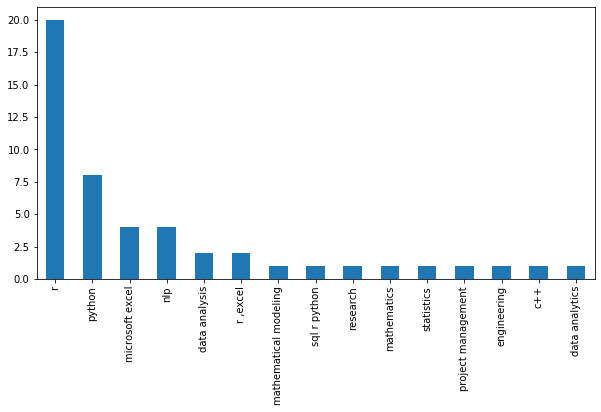

In [165]:
plt.figure(figsize=(10,5))
plt.tight_layout()
skills=jobs['skills'].dropna()
skills.value_counts().nlargest(15).plot(kind='bar')


In [176]:
about_df = jobs[['about']].copy()
about_df

about
0                                                                                                    NaN
1                                                                                                    NaN
2    Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...
3                                                                                                    NaN
4    Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...
..                                                                                                   ...
587                                                                                                  NaN
588  A goal oriented data scientist with research experience in machine learning and computer vision....
589  I love solving puzzles. I don't like to babble.\r\n\r\nIf you're a recruiter: http://nadbordrozd...
590                                                                                                  NaN
591                                                                                                  NaN

[592 rows x 1 columns]

In [178]:
about_df.isna().sum()


about    330
dtype: int64

In [180]:
about_df =  about_df[about_df['about'].notna()]

In [181]:
about_df

about
2    Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...
4    Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...
5    Mahdi Ghanbari received his bachelor degree in applied mathematics, application in computer in K...
6    A passionate, hard-working, and result-driven HR Professional with 8 years of experience. Deep k...
7    Proactive (not a joke), enthusiastic data scientist, Masters degree in Intellectual Data Analysi...
..                                                                                                   ...
580  Skilled Business Analyst with 8 years experience working across software delivery and business c...
581  University of Cambridge Physics Masters graduate.\r\n\r\nCurrently working as a data scientist. ...
585  I am an analytical thinker who is driven to excel in everything I take on. I thrive in high pres...
588  A goal oriented data scientist with research experience in machine learning and computer vision....
589  I love solving puzzles. I don't like to babble.\r\n\r\nIf you're a recruiter: http://nadbordrozd...

[262 rows x 1 columns]

In [182]:
import string
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'[^a-zA-Z0-9 \n\.]', ' ' , text)
    text = text.replace('\n', ' ')
    return text

about_df['about_punct'] = about_df["about"].apply(lambda x: remove_punct(x))
about_df.head(10)

C:\Users\behdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


about  \
2   Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
4   Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   
5   Mahdi Ghanbari received his bachelor degree in applied mathematics, application in computer in K...   
6   A passionate, hard-working, and result-driven HR Professional with 8 years of experience. Deep k...   
7   Proactive (not a joke), enthusiastic data scientist, Masters degree in Intellectual Data Analysi...   
8   Aspiring Data Scientist currently studying full-time towards completing an MSc in Data Science a...   
10  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   
13  I have recently undertaking my masters at the University of Southampton in Systems, Control and ...   
14  I am a Data Scientist with more than 15 years IT experience. Can work through any Data set from ...   
15  Data and information is my interest, and my passion – the bigger and more complex, the better!\r...   

                                                                                            about_punct  
2   Machine learningDeep learning PythonR NLPSpacynltkgensim Statistical analysisI have  IT experien...  
4   Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vi...  
5   Mahdi Ghanbari received his bachelor degree in applied mathematics application in computer in Kh...  
6   A passionate hardworking and resultdriven HR Professional with  years of experience Deep knowled...  
7   Proactive not a joke enthusiastic data scientist Masters degree in Intellectual Data Analysis MA...  
8   Aspiring Data Scientist currently studying fulltime towards completing an MSc in Data Science at...  
10  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vi...  
13  I have recently undertaking my masters at the University of Southampton in Systems Control and S...  
14  I am a Data Scientist with more than  years IT experience Can work through any Data set from cle...  
15  Data and information is my interest and my passion   the bigger and more complex the better    A...

In [184]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

about_df['about_tokenized'] = about_df['about_punct'] .apply(lambda x: tokenization(x.lower()))
about_df.head()

C:\Users\behdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


about  \
2  Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
4  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   
5  Mahdi Ghanbari received his bachelor degree in applied mathematics, application in computer in K...   
6  A passionate, hard-working, and result-driven HR Professional with 8 years of experience. Deep k...   
7  Proactive (not a joke), enthusiastic data scientist, Masters degree in Intellectual Data Analysi...   

                                                                                           about_punct  \
2  Machine learningDeep learning PythonR NLPSpacynltkgensim Statistical analysisI have  IT experien...   
4  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vi...   
5  Mahdi Ghanbari received his bachelor degree in applied mathematics application in computer in Kh...   
6  A passionate hardworking and resultdriven HR Professional with  years of experience Deep knowled...   
7  Proactive not a joke enthusiastic data scientist Masters degree in Intellectual Data Analysis MA...   

                                                                                       about_tokenized  
2  [machine, learningdeep, learning, pythonr, nlpspacynltkgensim, statistical, analysisi, have, it,...  
4  [leading, a, team, of, data, scientists, at, jio, to, create, solutions, for, different, ai, pro...  
5  [mahdi, ghanbari, received, his, bachelor, degree, in, applied, mathematics, application, in, co...  
6  [a, passionate, hardworking, and, resultdriven, hr, professional, with, years, of, experience, d...  
7  [proactive, not, a, joke, enthusiastic, data, scientist, masters, degree, in, intellectual, data...

In [185]:
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
about_df['about_nonstop'] = about_df['about_tokenized'].apply(lambda x: remove_stopwords(x))
about_df.head(10)

C:\Users\behdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


about  \
2   Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
4   Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   
5   Mahdi Ghanbari received his bachelor degree in applied mathematics, application in computer in K...   
6   A passionate, hard-working, and result-driven HR Professional with 8 years of experience. Deep k...   
7   Proactive (not a joke), enthusiastic data scientist, Masters degree in Intellectual Data Analysi...   
8   Aspiring Data Scientist currently studying full-time towards completing an MSc in Data Science a...   
10  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   
13  I have recently undertaking my masters at the University of Southampton in Systems, Control and ...   
14  I am a Data Scientist with more than 15 years IT experience. Can work through any Data set from ...   
15  Data and information is my interest, and my passion – the bigger and more complex, the better!\r...   

                                                                                            about_punct  \
2   Machine learningDeep learning PythonR NLPSpacynltkgensim Statistical analysisI have  IT experien...   
4   Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vi...   
5   Mahdi Ghanbari received his bachelor degree in applied mathematics application in computer in Kh...   
6   A passionate hardworking and resultdriven HR Professional with  years of experience Deep knowled...   
7   Proactive not a joke enthusiastic data scientist Masters degree in Intellectual Data Analysis MA...   
8   Aspiring Data Scientist currently studying fulltime towards completing an MSc in Data Science at...   
10  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vi...   
13  I have recently undertaking my masters at the University of Southampton in Systems Control and S...   
14  I am a Data Scientist with more than  years IT experience Can work through any Data set from cle...   
15  Data and information is my interest and my passion   the bigger and more complex the better    A...   

                                                                                        about_tokenized  \
2   [machine, learningdeep, learning, pythonr, nlpspacynltkgensim, statistical, analysisi, have, it,...   
4   [leading, a, team, of, data, scientists, at, jio, to, create, solutions, for, different, ai, pro...   
5   [mahdi, ghanbari, received, his, bachelor, degree, in, applied, mathematics, application, in, co...   
6   [a, passionate, hardworking, and, resultdriven, hr, professional, with, years, of, experience, d...   
7   [proactive, not, a, joke, enthusiastic, data, scientist, masters, degree, in, intellectual, data...   
8   [aspiring, data, scientist, currently, studying, fulltime, towards, completing, an, msc, in, dat...   
10  [leading, a, team, of, data, scientists, at, jio, to, create, solutions, for, different, ai, pro...   
13  [i, have, recently, undertaking, my, masters, at, the, university, of, southampton, in, systems,...   
14  [i, am, a, data, scientist, with, more, than, years, it, experience, can, work, through, any, da...   
15  [data, and, information, is, my, interest, and, my, passion, the, bigger, and, more, complex, th...   

                                                                                          about_nonstop  
2   [machine, learningdeep, learning, pythonr, nlpspacynltkgensim, statistical, analysisi, experienc...  
4   [leading, team, data, scientists, jio, create, solutions, different, ai, problems, nlp, vision, ...  
5   [mahdi, ghanbari, received, bachelor, degree, applied, mathematics, application, computer, khaje...  
6   [passionate, hardworking, resultdriven, hr, professional, years, experience, deep, knowledge, pe...  
7   [proactive, joke, enthusiastic

In [186]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

about_df['about_stemmed'] =about_df['about_nonstop'] .apply(lambda x: stemming(x))
about_df.head()

C:\Users\behdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


about  \
2  Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
4  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   
5  Mahdi Ghanbari received his bachelor degree in applied mathematics, application in computer in K...   
6  A passionate, hard-working, and result-driven HR Professional with 8 years of experience. Deep k...   
7  Proactive (not a joke), enthusiastic data scientist, Masters degree in Intellectual Data Analysi...   

                                                                                           about_punct  \
2  Machine learningDeep learning PythonR NLPSpacynltkgensim Statistical analysisI have  IT experien...   
4  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vi...   
5  Mahdi Ghanbari received his bachelor degree in applied mathematics application in computer in Kh...   
6  A passionate hardworking and resultdriven HR Professional with  years of experience Deep knowled...   
7  Proactive not a joke enthusiastic data scientist Masters degree in Intellectual Data Analysis MA...   

                                                                                       about_tokenized  \
2  [machine, learningdeep, learning, pythonr, nlpspacynltkgensim, statistical, analysisi, have, it,...   
4  [leading, a, team, of, data, scientists, at, jio, to, create, solutions, for, different, ai, pro...   
5  [mahdi, ghanbari, received, his, bachelor, degree, in, applied, mathematics, application, in, co...   
6  [a, passionate, hardworking, and, resultdriven, hr, professional, with, years, of, experience, d...   
7  [proactive, not, a, joke, enthusiastic, data, scientist, masters, degree, in, intellectual, data...   

                                                                                         about_nonstop  \
2  [machine, learningdeep, learning, pythonr, nlpspacynltkgensim, statistical, analysisi, experienc...   
4  [leading, team, data, scientists, jio, create, solutions, different, ai, problems, nlp, vision, ...   
5  [mahdi, ghanbari, received, bachelor, degree, applied, mathematics, application, computer, khaje...   
6  [passionate, hardworking, resultdriven, hr, professional, years, experience, deep, knowledge, pe...   
7  [proactive, joke, enthusiastic, data, scientist, masters, degree, intellectual, data, analysis, ...   

                                                                                         about_stemmed  
2  [machin, learningdeep, learn, pythonr, nlpspacynltkgensim, statist, analysisi, experi, life, lon...  
4  [lead, team, data, scientist, jio, creat, solut, differ, ai, problem, nlp, vision, audio, indivi...  
5  [mahdi, ghanbari, receiv, bachelor, degre, appli, mathemat, applic, comput, khaje, nasir, univer...  
6  [passion, hardwork, resultdriven, hr, profession, year, experi, deep, knowledg, perform, manag, ...  
7  [proactiv, joke, enthusiast, data, scientist, master, degre, intellectu, data, analysi, econom, ...

In [187]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

about_df['about_lemmatized'] = about_df['about_stemmed'].apply(lambda x: lemmatizer(x))
about_df.head()

C:\Users\behdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


about  \
2  Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
4  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   
5  Mahdi Ghanbari received his bachelor degree in applied mathematics, application in computer in K...   
6  A passionate, hard-working, and result-driven HR Professional with 8 years of experience. Deep k...   
7  Proactive (not a joke), enthusiastic data scientist, Masters degree in Intellectual Data Analysi...   

                                                                                           about_punct  \
2  Machine learningDeep learning PythonR NLPSpacynltkgensim Statistical analysisI have  IT experien...   
4  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vi...   
5  Mahdi Ghanbari received his bachelor degree in applied mathematics application in computer in Kh...   
6  A passionate hardworking and resultdriven HR Professional with  years of experience Deep knowled...   
7  Proactive not a joke enthusiastic data scientist Masters degree in Intellectual Data Analysis MA...   

                                                                                       about_tokenized  \
2  [machine, learningdeep, learning, pythonr, nlpspacynltkgensim, statistical, analysisi, have, it,...   
4  [leading, a, team, of, data, scientists, at, jio, to, create, solutions, for, different, ai, pro...   
5  [mahdi, ghanbari, received, his, bachelor, degree, in, applied, mathematics, application, in, co...   
6  [a, passionate, hardworking, and, resultdriven, hr, professional, with, years, of, experience, d...   
7  [proactive, not, a, joke, enthusiastic, data, scientist, masters, degree, in, intellectual, data...   

                                                                                         about_nonstop  \
2  [machine, learningdeep, learning, pythonr, nlpspacynltkgensim, statistical, analysisi, experienc...   
4  [leading, team, data, scientists, jio, create, solutions, different, ai, problems, nlp, vision, ...   
5  [mahdi, ghanbari, received, bachelor, degree, applied, mathematics, application, computer, khaje...   
6  [passionate, hardworking, resultdriven, hr, professional, years, experience, deep, knowledge, pe...   
7  [proactive, joke, enthusiastic, data, scientist, masters, degree, intellectual, data, analysis, ...   

                                                                                         about_stemmed  \
2  [machin, learningdeep, learn, pythonr, nlpspacynltkgensim, statist, analysisi, experi, life, lon...   
4  [lead, team, data, scientist, jio, creat, solut, differ, ai, problem, nlp, vision, audio, indivi...   
5  [mahdi, ghanbari, receiv, bachelor, degre, appli, mathemat, applic, comput, khaje, nasir, univer...   
6  [passion, hardwork, resultdriven, hr, profession, year, experi, deep, knowledg, perform, manag, ...   
7  [proactiv, joke, enthusiast, data, scientist, master, degre, intellectu, data, analysi, econom, ...   

                                                                                      about_lemmatized  
2  [machin, learningdeep, learn, pythonr, nlpspacynltkgensim, statist, analysisi, experi, life, lon...  
4  [lead, team, data, scientist, jio, creat, solut, differ, ai, problem, nlp, vision, audio, indivi...  
5  [mahdi, ghanbari, receiv, bachelor, degre, appli, mathemat, applic, comput, khaje, nasir, univer...  
6  [passion, hardwork, resultdriven, hr, profession, year, experi, deep, knowledg, perform, manag, ...  
7  [proactiv, joke, enthusiast, data, scientist, master, degre, intellectu, data, analysi, econom, ...

In [188]:
from nltk.tokenize import word_tokenize

# Uncomment this line if you haven't downloaded punkt before
# or just run it as it is and uncomment it if you got an error.
# nltk.download('punkt')

def most_used_words(text):
    tokens = word_tokenize(text)
    frequency_dist = nltk.FreqDist(tokens)
    print("There is %d different words" % len(set(text)))
    return sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

In [189]:
words = set(nltk.corpus.words.words())

test_text_data = " ".join(w for w in nltk.wordpunct_tokenize(about_df.about.str.cat()) \
         if w.lower() in words or not w.isalpha())


In [190]:
most_used_words(test_text_data)[:10]

There is 106 different words


[',', 'and', '.', 'in', 'of', 'to', 'the', '-', 'a', 'I']

In [191]:
mw = most_used_words(about_df.about.str.cat())
most_words = []
for w in mw:
    if len(most_words) == 1000:
        break
    if w in stopwords.words("english"):
        continue
    else:
        most_words.append(w)

There is 111 different words


In [192]:
sorted(most_words)

['!',
 '#',
 '%',
 '&',
 "'",
 "''",
 "'m",
 "'re",
 "'s",
 "'ve",
 '(',
 ')',
 '*',
 ',',
 '-',
 '--',
 '.',
 '...',
 '/',
 '1',
 '10',
 '100',
 '15',
 '2',
 '2012',
 '2013',
 '2014',
 '2016',
 '2017',
 '2018',
 '2019',
 '3',
 '3D',
 '4',
 '5',
 '5+',
 '6',
 '7',
 '9',
 ':',
 ';',
 '>',
 '?',
 '@',
 'A',
 'AI',
 'API',
 'AWS',
 'Access',
 'Acquisition',
 'Additional',
 'Adept',
 'Advanced',
 'After',
 'Agile',
 'Algorithm',
 'Algorithms',
 'Also',
 'Always',
 'Amazon',
 'An',
 'Analysis',
 'Analyst',
 'Analytics',
 'Apache',
 'Application',
 'Applied',
 'Artificial',
 'As',
 'Associate',
 'At',
 'Azure',
 'BI',
 'BSc',
 'Bank',
 'Bash',
 'Bayes',
 'Bayesian',
 'Before',
 'Big',
 'Boosting',
 'British',
 'Building',
 'Business',
 'C',
 'C++',
 'Calypso',
 'Certified',
 'Class',
 'Classification',
 'Cloud',
 'Clustering',
 'College',
 'Comfortable',
 'Computational',
 'Computer',
 'Computing',
 'Consultancy',
 'Consultant',
 'Control',
 'Creative',
 'Credit',
 'Currently',
 'Customer',


In [193]:
# I'm defining this function to use it in the 
# Data Preparation Phase
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet')
def stem_tokenize(text):
    stemmer = SnowballStemmer("english")
    stemmer = WordNetLemmatizer()
    return [stemmer.lemmatize(token) for token in word_tokenize(text)]

def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

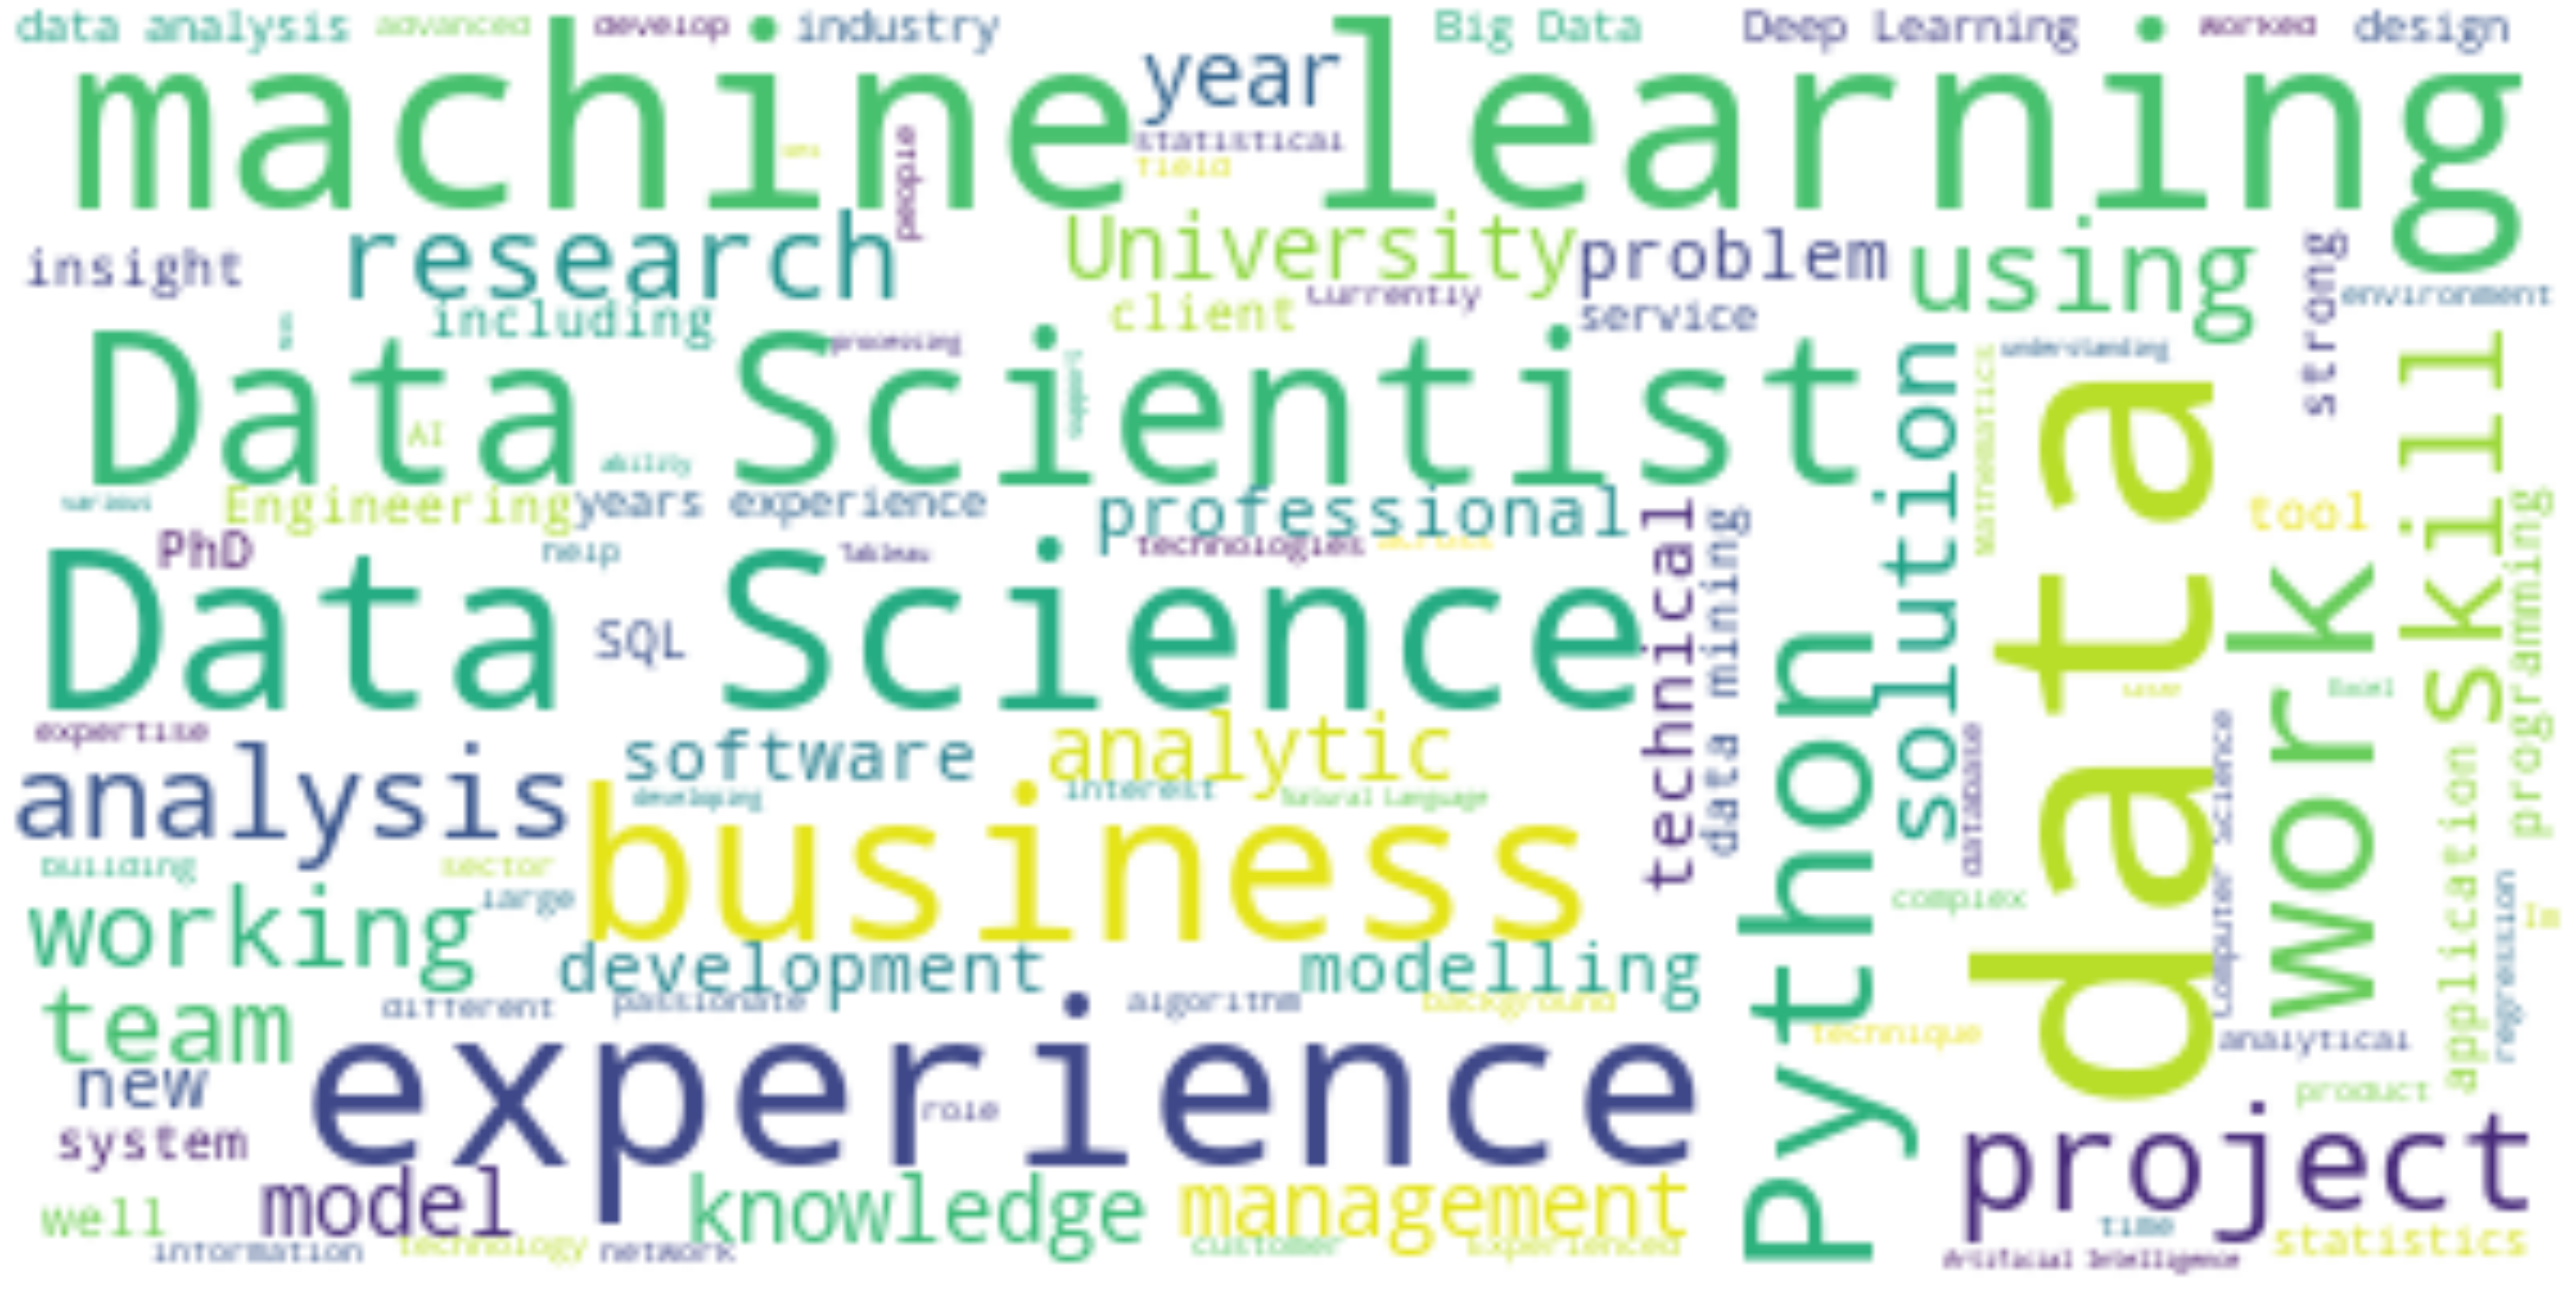

In [194]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
# Start with one review:
text = " ".join(about for about in about_df.about_punct)
# lower max_font_size, change the maximum number of word and lighten the background:
stopwords = set(STOPWORDS)
# stopwords.add(search_modifier)
wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords= stopwords ,  background_color="white").generate(text)
wordcloud.to_file('about.png')
plt.figure(figsize=(100,50))
plt.tight_layout()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# plt.savefig('wordcloud.png')

## working on education

In [202]:
pros = pd.read_csv("result_v2.csv",index_col=False)
pros

name                                           job_title  \
0           Andria Sarri                                      Data Scientist   
1         Saksham Jindal                 Data Scientist at Fractal Analytics   
2          Rahul Jaiswal                  Data Scientist at HCL Technologies   
3         Vaibhav Sharma                           Data Scientist at ZappyAI   
4            Paras Ahuja                               Data Scientist at Jio   
..                   ...                                                 ...   
587     Anna Padkavyrava                       Data Scientist at Brave Bison   
588   Konstantinos Bozas  Senior Data Scientist at Amazon | Machine Learning   
589         Nadbor Drozd         Lead Data Scientist at Lloyds Banking Group   
590  Christopher Ottesen                                      Data Scientist   
591            Ben Adler                   Data Scientist - NLP at Logically   

          current_company  \
0                    HSBC   
1       Fractal Analytics   
2        HCL Technologies   
3                 ZappyAI   
4                     Jio   
..                    ...   
587           Brave Bison   
588                Amazon   
589  Lloyds Banking Group   
590                    BP   
591             Logically   

                                                          university  \
0                                                                UCL   
1                          Indian Institute of Technology, Kharagpur   
2                                              Academy of Technology   
3                                             London Business School   
4                                                                NaN   
..                                                               ...   
587  Belarusian State University of Informatics and Radioelectronics   
588                                         Queen Mary, U. of London   
589                                             University of Warsaw   
590                                                              NaN   
591                                              University of Leeds   

                                                                               degree  \
0                                                        Doctor of Philosophy (Ph.D.)   
1    Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
2                                                      BTech - Bachelor of Technology   
3                                                 Masters in Analytics and Management   
4                                                                                 NaN   
..                                                                                ...   
587                                                                   Master’s Degree   
588                                                                               PhD   
589                                                                               M.S   
590                                                                               NaN   
591                                                                               BSc   

                                   location  \
0    London, Greater London, United Kingdom   
1                    London, United Kingdom   
2                    London, United Kingdom   
3    London, Greater London, United Kingdom   
4                    London, United Kingdom   
..                                      ...   
587  London, Greater London, United Kingdom   
588                  London, United Kingdom   
589  London, Greater London, United Kingdom   
590  London, Greater London, United Kingdom   
591         Farnham, Surrey, United Kingdom   

                                                                                                   about  \
0                                                                                                    Na

In [207]:
pros['degree'].isna().sum()

79

In [245]:
list_edu = pros['degree'].dropna().to_frame()
list_edu

degree
0                                                        Doctor of Philosophy (Ph.D.)
1    Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))
2                                                      BTech - Bachelor of Technology
3                                                 Masters in Analytics and Management
5                                                        Doctor of Philosophy (Ph.D.)
..                                                                                ...
586                                                      Doctor of Philosophy (Ph.D.)
587                                                                   Master’s Degree
588                                                                               PhD
589                                                                               M.S
591                                                                               BSc

[513 rows x 1 columns]

In [223]:
pros['degree'].unique()

array(['Doctor of Philosophy (Ph.D.)',
       'Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))',
       'BTech - Bachelor of Technology',
       'Masters in Analytics and Management', nan,
       'Master of Arts (M.A.)', 'Doctor of Philosophy - PhD',
       "Engineer's Degree", 'Master of Science (MSc)',
       'MSc System, Control and Signal Processing', 'Master’s Degree',
       'Doctor of Philosophy (PhD), Master of Science (MS)',
       'Verified Certificate Blockchain Technology', "Bachelor's degree",
       'Master of Science - MS', 'Doctor of Philosophy (PhD)',
       'Master of Science (M.Sc.)', "Master's degree", 'Graduate Diploma',
       'Master of Mathematics', 'Masters', 'MSc Data Science', 'Msc',
       'MSc', 'Bachelor’s Degree', 'Bachelor of Science (BSc)',
       'Master of Business Administration - MBA',
       'Master of Philosophy (MPhil)', 'Bachelor of Engineering (B.E.)',
       "Master's Degree", 'D.Phil.', 'Master Degree',
      

In [254]:
list_edu['degree'].replace("Doctor of Philosophy (Ph.D.)", "Ph.D.", inplace = True)
list_edu['degree'].replace("Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))", "Master", inplace = True)
list_edu['degree'].replace("BTech - Bachelor of Technology", "Bachelor", inplace = True)
list_edu['degree'].replace("Masters in Analytics and Management", "Master", inplace = True)
list_edu['degree'].replace("Engineer's Degree", "Others", inplace = True)
list_edu['degree'].replace("Doctor of Philosophy - PhD", "Ph.D.", inplace = True)
list_edu['degree'].replace("Master of Science (MSc)", "Master", inplace = True)
list_edu['degree'].replace("MSc System, Control and Signal Processing", "Master", inplace = True)
list_edu['degree'].replace("Master’s Degree", "Master", inplace = True)
list_edu['degree'].replace("Doctor of Philosophy (PhD), Master of Science (MS)", "Ph.D.", inplace = True)
list_edu['degree'].replace("Verified Certificate Blockchain Technology", "Others", inplace = True)
list_edu['degree'].replace("Bachelor's degree","Bachelor", inplace = True)
list_edu['degree'].replace("Master of Science - MS", "Master", inplace = True)
list_edu['degree'].replace("Master of Science (M.Sc.)", "Master", inplace = True)
list_edu['degree'].replace("Master's degree", "Master", inplace = True)
list_edu['degree'].replace("Graduate Diploma", "Others", inplace = True)
list_edu['degree'].replace("Master of Mathematics", "Master", inplace = True)
list_edu['degree'].replace("Masters", "Master", inplace = True)
list_edu['degree'].replace("MSc Data Science", "Master", inplace = True)
list_edu['degree'].replace("Msc", "Master", inplace = True)
list_edu['degree'].replace("MSc", "Master", inplace = True)
list_edu['degree'].replace("Bachelor’s Degree", "Bachelor", inplace = True)
list_edu['degree'].replace("Bachelor of Science (BSc)", "Bachelor", inplace = True)
list_edu['degree'].replace("Master of Business Administration - MBA", "Master", inplace = True)
list_edu['degree'].replace("Master of Philosophy (MPhil)", "Master", inplace = True)
list_edu['degree'].replace("Bachelor of Engineering (B.E.)", "Bachelor", inplace = True)
list_edu['degree'].replace("Master's Degree", "Master", inplace = True)
list_edu['degree'].replace("D.Phil.", "Ph.D.", inplace = True)
list_edu['degree'].replace("Master Degree", "Master", inplace = True)
list_edu['degree'].replace("Post Graduate Program in Business Analytics and Business Intelligence", "Master", inplace = True)
list_edu['degree'].replace("Msc Data Science - (Application Pending)", "Master", inplace = True)
list_edu['degree'].replace("Postgraduate Program in Big Data and Business Analytics", "Master", inplace = True)
list_edu['degree'].replace("Computer Science", "Others", inplace = True)
list_edu['degree'].replace("MRes", "Others", inplace = True)
list_edu['degree'].replace("Diplom", "Others", inplace = True)
list_edu['degree'].replace("PhD", "Ph.D.", inplace = True)
list_edu['degree'].replace("Data Science Immersive", "Others", inplace = True)
list_edu['degree'].replace("Master of Engineering (MEng)", "Master", inplace = True)
list_edu['degree'].replace("Master of Engineering - MEng", "Master", inplace = True)
list_edu['degree'].replace("Doctorate", "Ph.D.", inplace = True)
list_edu['degree'].replace("Master of Science", "Master", inplace = True)
list_edu['degree'].replace("Bachelor of Science (BSc) Hons", "Bachelor", inplace = True)
list_edu['degree'].replace("Certificate Programme in Business Analytics", "Others", inplace = True)
list_edu['degree'].replace("Bachelor of Science - BS, First Class Honours", "Bachelor", inplace = True)
list_edu['degree'].replace("Nanodegree Program", "Others", inplace = True)
list_edu['degree'].replace("Bachelor of Applied Science - BASc", "Bachelor", inplace = True)
list_edu['degree'].replace("MSc by Research", "Master", inplace = True)
list_edu['degree'].replace("Master of Science - MSc", "Master", inplace = True)
list_edu['degree'].replace("Bachelor's Degree", "Bachelor", inplace = True)
list_edu['degree'].replace("BSc + MSc", "Master", inplace = True)
list_edu['degree'].replace("Msc Advanced Computing(Big Data)", "Master", inplace = True)
list_edu['degree'].replace("BSc", "Bachelor", inplace = True)
list_edu['degree'].replace("Master of Science (MS)", "Master", inplace = True)
list_edu['degree'].replace("MSc Digital & Technology Solutions Specialist: Data Analytics (Part-Time)", "Master", inplace = True)
list_edu['degree'].replace("Master of Science in Business Analytics (MSBA)", "Master", inplace = True)
list_edu['degree'].replace("BSc (Hons)", "Bachelor", inplace = True)
list_edu['degree'].replace("Bachelor of Technology (B.Tech.)", "Bachelor", inplace = True)
list_edu['degree'].replace("Data Science", "Others", inplace = True)
list_edu['degree'].replace("Bachelor of Engineering (B.Eng.)", "Bachelor", inplace = True)
list_edu['degree'].replace("MSC", "Master", inplace = True)
list_edu['degree'].replace("Bachelor of Science - BS", "Bachelor", inplace = True)
list_edu['degree'].replace("Data Science Path", "Others", inplace = True)
list_edu['degree'].replace("Building Successful Products and Agile Product Management", "Others", inplace = True)
list_edu['degree'].replace("D.Phil. in Experimental Psychology", "Ph.D.", inplace = True)
list_edu['degree'].replace("3 Yrs Diploma in Hotel Management", "Others", inplace = True)
list_edu['degree'].replace("Geophysics", "Others", inplace = True)
list_edu['degree'].replace("MSc Business Analytics", "Master", inplace = True)
list_edu['degree'].replace("Masers in Advanced Computer Science", "Master", inplace = True)
list_edu['degree'].replace("Executive Program in Managing Business decisions", "Master", inplace = True)
list_edu['degree'].replace("MEng Mathematical Computation", "Master", inplace = True)
list_edu['degree'].replace("Master of Science in Engineering (MSE)", "Master", inplace = True)
list_edu['degree'].replace("MSci", "Master", inplace = True)
list_edu['degree'].replace("Bachelor of Arts (BA)", "Bachelor", inplace = True)
list_edu['degree'].replace("Bachelor of Engineering (BEng)", "Bachelor", inplace = True)
list_edu['degree'].replace("Nanodegree", "Others", inplace = True)
list_edu['degree'].replace("Engineering Science, First Class Honours", "Bachelor", inplace = True)
list_edu['degree'].replace("BTEC National Diploma in Sport", "Bachelor", inplace = True)
list_edu['degree'].replace("BCom", "Bachelor", inplace = True)
list_edu['degree'].replace("MSc Artificial Intelligence", "Master", inplace = True)
list_edu['degree'].replace("PGCE in Physics with Science", "Others", inplace = True)
list_edu['degree'].replace("Master of Reseach (MRes)", "Master", inplace = True)
list_edu['degree'].replace("Phd", "Ph.D.", inplace = True)
list_edu['degree'].replace("MSC Data Science", "Master", inplace = True)
list_edu['degree'].replace("Diploma Automation and Electrial Engineer", "Others", inplace = True)
list_edu['degree'].replace("Advanced", "Others", inplace = True)
list_edu['degree'].replace("Natural Sciences", "Others", inplace = True)
list_edu['degree'].replace("Bachelor of Laws - LLB", "Bachelor", inplace = True)
list_edu['degree'].replace("Master of Business Administration (M.B.A.)", "Master", inplace = True)
list_edu['degree'].replace("Data Science Part-time", "Others", inplace = True)
list_edu['degree'].replace("Web Science and Big Data Analytics", "Others", inplace = True)
list_edu['degree'].replace("master in Applied mathematics and informatics", "Master", inplace = True)
list_edu['degree'].replace("BA (I)", "Bachelor", inplace = True)
list_edu['degree'].replace("Mathematics", "Others", inplace = True)
list_edu['degree'].replace("Data Science - Data to Insights", "Others", inplace = True)
list_edu['degree'].replace("Bachelor of Mathematcs", "Bachelor", inplace = True)
list_edu['degree'].replace("MS", "Master", inplace = True)
list_edu['degree'].replace("PhD Immunology", "Ph.D.", inplace = True)
list_edu['degree'].replace("Msc Data Science and Analytics.", "Master", inplace = True)
list_edu['degree'].replace("Master of Science - Msc", "Master", inplace = True)
list_edu['degree'].replace("Bachelor of Engineering - BE", "Bachelor", inplace = True)
list_edu['degree'].replace("BCom (Hons)", "Bachelor", inplace = True)
list_edu['degree'].replace("Master of Computer Applications (M.C.A.)", "Master", inplace = True)
list_edu['degree'].replace("Artificial Intelligence", "Others", inplace = True)
list_edu['degree'].replace("MSCI Software developement", "Master", inplace = True)
list_edu['degree'].replace("Master of Mathematics in Mathematics and Computer Science (with a year in industry)", "Master", inplace = True)
list_edu['degree'].replace("B.S.", "Bachelor", inplace = True)
list_edu['degree'].replace("Bachelor of Science (B.Sc.)", "Bachelor", inplace = True)
list_edu['degree'].replace("BSc Software Engineering", "Bachelor", inplace = True)
list_edu['degree'].replace("BSc (Hons) Natural Sciences - Physics", "Bachelor", inplace = True)
list_edu['degree'].replace("MSc Business Systems Analysis and Design", "Master", inplace = True)
list_edu['degree'].replace("PGCert", "Others", inplace = True)
list_edu['degree'].replace("Big Data Certificate", "Others", inplace = True)
list_edu['degree'].replace("Ph.D", "Ph.D.", inplace = True)
list_edu['degree'].replace("LSE Data Analysis for Management Programme", "Others", inplace = True)
list_edu['degree'].replace("Development of management skills", "Others", inplace = True)
list_edu['degree'].replace("Bacharelado em Ciência da Computação", "Bachelor", inplace = True)
list_edu['degree'].replace("Information Engineering", "Bachelor", inplace = True)
list_edu['degree'].replace("Data Science and Big Data Analytics", "Others", inplace = True)
list_edu['degree'].replace("Postgraduate research in statistics", "Master", inplace = True)
list_edu['degree'].replace("BA", "Bachelor", inplace = True)
list_edu['degree'].replace("PhD student", "Ph.D.", inplace = True)
list_edu['degree'].replace("Physics with Astronomy", "Others", inplace = True)
list_edu['degree'].replace("Integrated Master in Science", "Master", inplace = True)
list_edu['degree'].replace("BSc Mathematics, Operational Research, Statistics & Economics", "Bachelor", inplace = True)
list_edu['degree'].replace("BSc Hons Computing Systems", "Bachelor", inplace = True)
list_edu['degree'].replace("BSc 1st Class Honours", "Bachelor", inplace = True)
list_edu['degree'].replace("One year of PhD research, voluntary withdrawal from study", "Others", inplace = True)
list_edu['degree'].replace("MSc Data Science & Analytics", "Master", inplace = True)
list_edu['degree'].replace("B.Sc.", "Bachelor", inplace = True)
list_edu['degree'].replace("Master of Science (MSci)", "Master", inplace = True)
list_edu['degree'].replace("Master of Engineering (M.Eng.)", "Master", inplace = True)
list_edu['degree'].replace("Data Science and Big Data Analytics, Executive Programme", "Others", inplace = True)
list_edu['degree'].replace("Masters, Analytics and Management", "Master", inplace = True)
list_edu['degree'].replace("Master's in Analytics and Management", "Masters", inplace = True)
list_edu['degree'].replace("Masters in Analytics and Management (MAM2020)", "Masters", inplace = True)
list_edu['degree'].replace("MSc Master Analytics and Management", "Masters", inplace = True)
list_edu['degree'].replace("B. Tech.", "Bachelor", inplace = True)
list_edu['degree'].replace("MSc.", "Masters", inplace = True)
list_edu['degree'].replace("Accounting and Finance", "Others", inplace = True)
list_edu['degree'].replace("Bachelor of Medicine, Bachelor of Surgery - MBBS", "Bachelor", inplace = True)
list_edu['degree'].replace("Marketing Management", "Bachelor", inplace = True)
list_edu['degree'].replace("French Language and Literature", "Others", inplace = True)
list_edu['degree'].replace("Executive MBA", "Masters", inplace = True)
list_edu['degree'].replace("Doctor", "Ph.D.", inplace = True)
list_edu['degree'].replace("Research (MPhill)", "Ph.D.", inplace = True)
list_edu['degree'].replace("BS", "Bachelor", inplace = True)
list_edu['degree'].replace("Doctor of Philosophy (PhD), Electronic Engineering and Computer Science", "Ph.D.", inplace = True)
list_edu['degree'].replace("BA (Hons)", "Bachelor", inplace = True)
list_edu['degree'].replace("Bachelor’s Degree (Hons)", "Bachelor", inplace = True)
list_edu['degree'].replace("Master's Degree MSc", "Master", inplace = True)
list_edu['degree'].replace("Dual Degree (BS + MS)", "Master", inplace = True)
list_edu['degree'].replace("Master of Science (M.S.)", "Master", inplace = True)
list_edu['degree'].replace("PhD Stem Cell Biology", "Ph.D.", inplace = True)
list_edu['degree'].replace("CIM Diploma in Professional Marketing", "Others", inplace = True)
list_edu['degree'].replace("Sports Analytics and Big Data", "Others", inplace = True)
list_edu['degree'].replace("postgraduate", "Master", inplace = True)
list_edu['degree'].replace("M.ENG", "Master", inplace = True)
list_edu['degree'].replace("AS Business Studies", "Others", inplace = True)
list_edu['degree'].replace("Embedded systems with Computer Vision MSc", "Master", inplace = True)
list_edu['degree'].replace("MBA", "Master", inplace = True)
list_edu['degree'].replace("Habilitation (dr habil.)", "Others", inplace = True)
list_edu['degree'].replace("B(Eng)", "Bachelor", inplace = True)
list_edu['degree'].replace("Masters of Science (MSc)", "Master", inplace = True)
list_edu['degree'].replace("Graduate Certificate in Data Science", "Bachelor", inplace = True)
list_edu['degree'].replace("M.Sc. in Business Analytics (Data Science)", "Master", inplace = True)
list_edu['degree'].replace("Doctor of Philosophy (PhD)", "Ph.D.", inplace = True)
list_edu['degree'].replace("M.S", "Master", inplace = True)
list_edu['degree'].replace("Master of Arts (M.A.)", "Master", inplace = True)

In [255]:
list_edu

degree
0       Ph.D.
1      Master
2    Bachelor
3      Master
5       Ph.D.
..        ...
586     Ph.D.
587    Master
588     Ph.D.
589    Master
591  Bachelor

[513 rows x 1 columns]

In [256]:
list_edu['degree'].unique()

array(['Ph.D.', 'Master', 'Bachelor', 'Others'], dtype=object)

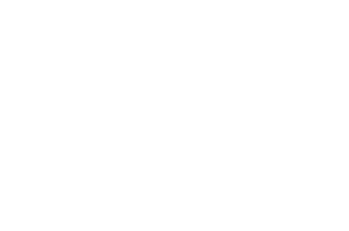

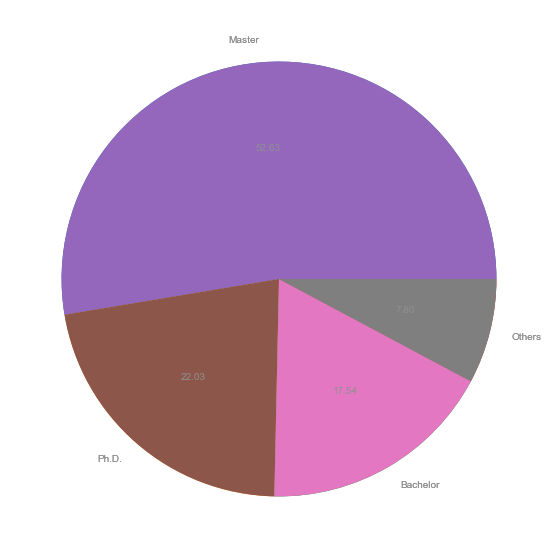

In [343]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show

labels = list_edu['degree'].value_counts().index
values = list_edu['degree'].value_counts().values

plt.axis('off')
plt.figure(figsize=(16,10))

plt.pie(values,labels=labels)
plt.pie(values, labels=labels, autopct='%.2f')
plt.show()


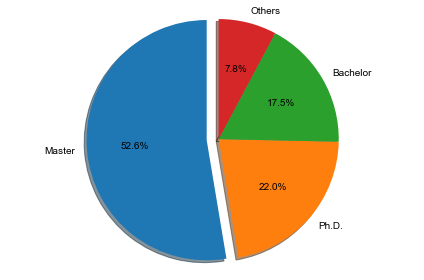

In [347]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.color'] = 'black'
# Pie chart
labels = list_edu['degree'].value_counts().index
sizes = list_edu['degree'].value_counts().values
# only "explode" the 1nd slice (i.e. 'Master')
explode = (0.1, 0, 0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('pie.png')
plt.show()

In [284]:
# find number of missing data based on each column
missing_data = pros.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("\n")

name
False    592
Name: name, dtype: int64


job_title
False    592
Name: job_title, dtype: int64


current_company
False    592
Name: current_company, dtype: int64


university
False    435
True     157
Name: university, dtype: int64


degree
False    513
True      79
Name: degree, dtype: int64


location
False    592
Name: location, dtype: int64


about
True     330
False    262
Name: about, dtype: int64


skills
True     540
False     52
Name: skills, dtype: int64


present_url
False    592
Name: present_url, dtype: int64


city
False    592
Name: city, dtype: int64


region
False    500
True      92
Name: region, dtype: int64


country
True     337
False    255
Name: country, dtype: int64




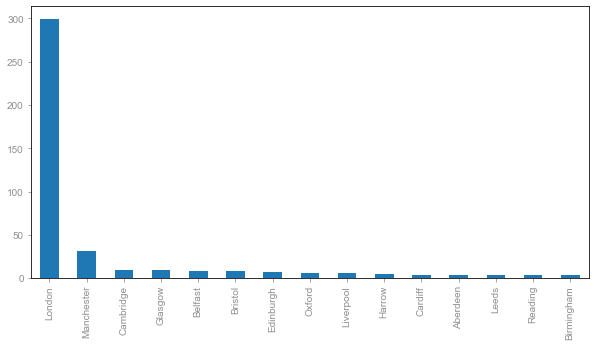

In [348]:
plt.figure(figsize=(10,5))
plt.tight_layout()

city = pros.loc[pros['city'] != 'United Kingdom']
city['city'].value_counts().nlargest(15).plot(kind='bar')
plt.savefig('bar.png')

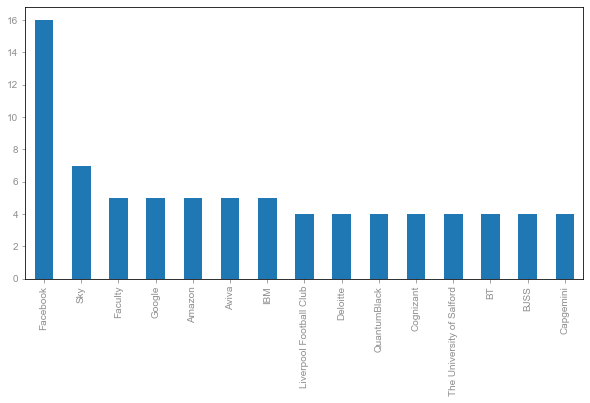

In [294]:
plt.figure(figsize=(10,5))
plt.tight_layout()


pros['current_company'].value_counts().nlargest(15).plot(kind='bar')

In [295]:
pros.head()

name                            job_title    current_company  \
0    Andria Sarri                       Data Scientist               HSBC   
1  Saksham Jindal  Data Scientist at Fractal Analytics  Fractal Analytics   
2   Rahul Jaiswal   Data Scientist at HCL Technologies   HCL Technologies   
3  Vaibhav Sharma            Data Scientist at ZappyAI            ZappyAI   
4     Paras Ahuja                Data Scientist at Jio                Jio   

                                  university  \
0                                        UCL   
1  Indian Institute of Technology, Kharagpur   
2                      Academy of Technology   
3                     London Business School   
4                                        NaN   

                                                                             degree  \
0                                                      Doctor of Philosophy (Ph.D.)   
1  Dual Degree (Bachelor of Technology (B.Tech.) + Masters of Technology (M.Tech.))   
2                                                    BTech - Bachelor of Technology   
3                                               Masters in Analytics and Management   
4                                                                               NaN   

                                 location  \
0  London, Greater London, United Kingdom   
1                  London, United Kingdom   
2                  London, United Kingdom   
3  London, Greater London, United Kingdom   
4                  London, United Kingdom   

                                                                                                 about  \
0                                                                                                  NaN   
1                                                                                                  NaN   
2  Machine learning,Deep learning, Python,R ,NLP(Spacy,nltk,gensim), Statistical analysis.I have 3+...   
3                                                                                                  NaN   
4  Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP, V...   

          skills                                           present_url  \
0  data analysis              https://www.linkedin.com/in/andriasarri/   
1            c++  https://www.linkedin.com/in/saksham-jindal-52b7b47a/   
2            NaN   https://www.linkedin.com/in/rahul-jaiswal-570042ab/   
3            NaN             https://www.linkedin.com/in/vaibhav9518s/   
4            NaN               https://www.linkedin.com/in/parasahuja/   

     city           region          country  
0  London   Greater London   United Kingdom  
1  London   United Kingdom              NaN  
2  London   United Kingdom              NaN  
3  London   Greater London   United Kingdom  
4  London   United Kingdom              NaN

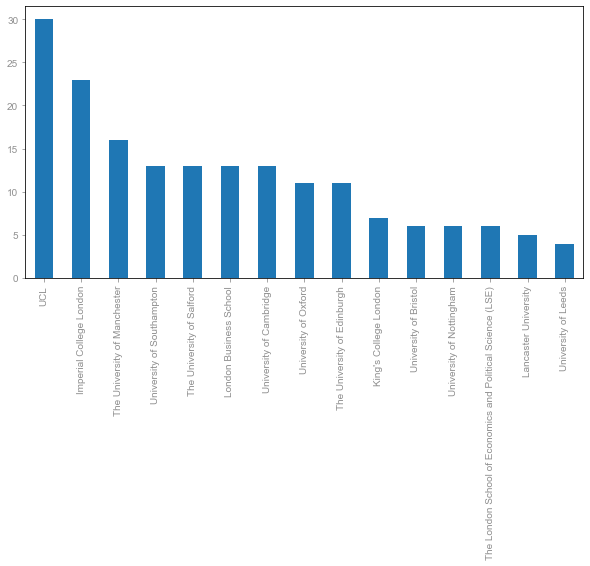

In [351]:
import matplotlib
matplotlib.rcParams['text.color'] = 'black'
plt.figure(figsize=(10,5))
plt.tight_layout()
unis=pros['university'].dropna()
unis.value_counts().nlargest(15).plot(kind='bar')

In [301]:
about_df.dtypes


about               object
about_punct         object
about_tokenized     object
about_nonstop       object
about_stemmed       object
about_lemmatized    object
dtype: object

## Frequency Analysis

In [297]:
#download nltk attribute if needed
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('reuters')

[nltk_data] Downloading package reuters to C:\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [302]:
text = ' '.join(description for description in about_df.about_punct)

In [303]:
text

'Machine learningDeep learning PythonR NLPSpacynltkgensim Statistical analysisI have  IT experience    I am life long learnerI never loseI either win or learn Leading a team of Data Scientists at Jio to create solutions for different AI problems in NLP Vision and Audio with individual contributions to each of the projects Additional responsibilities include collaborating with the product team to design features and toolchains needed to deploy AI at scale Mahdi Ghanbari received his bachelor degree in applied mathematics application in computer in Khaje nasir university and his MS in mathematics in Guilan university He also received his PhD in mathematics in Universiti Teknologi Malaysia in  He has published some articles in international journals conference proceedings His research interests includes optimazation data mining machine learning signal processing A passionate hardworking and resultdriven HR Professional with  years of experience Deep knowledge of Performance Management and

In [304]:
# tokenization
filtered_text = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

In [305]:
from nltk.corpus import stopwords
# stopwords
filtered_text = [word for word in filtered_text if word not in stopwords.words('english')]

In [306]:
# punctuation
filtered_text = [''.join(c for c in s if c not in string.punctuation) for s in filtered_text]
filtered_text = [s for s in filtered_text if s]

In [307]:
# lowercase
filtered_text = [word.lower() for word in filtered_text]

In [308]:
# Word Stemming
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
filtered_text_stem = [stemmer.stem(t) for t in filtered_text]

In [309]:
# Lemmatization
lemmatizer = nltk.WordNetLemmatizer()

filtered_text_lem = [lemmatizer.lemmatize(t) for t in filtered_text]

In [310]:
# NLTK Frequency Distributions
#nltkText = [filtered_text_stem, filtered_text_lem]

fdist = nltk.FreqDist(filtered_text_lem)

fdistDF = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
fdistDF = fdistDF.rename(columns={'index':'word', 0:'count'})
fdistDF = fdistDF.sort_values(by='count', ascending=False)
print('-----------------head words-----------------')
print(fdistDF.head(10).reset_index(drop=True))
print('-----------------tail words-----------------')
print(fdistDF.tail(10).reset_index(drop=True))

-----------------head words-----------------
         word  count
0        data    691
1           i    531
2    learning    276
3  experience    212
4     machine    196
5     science    194
6    business    176
7    analysis    151
8   scientist    135
9        year    118
-----------------tail words-----------------
                      word  count
0               originally      1
1                   tester      1
2                    honed      1
3                 relating      1
4              identifying      1
5               uncovering      1
6       visuallycompelling      1
7                teachable      1
8              spontaneous      1
9  httpnadbordrozdgithubio      1
